In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TSMixerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=27,
        output_chunk_length=1,
        hidden_size=128,
        activation="ReLU",
        num_blocks=1,
        norm_type="TimeBatchNorm2d",
        ff_size=132,
        normalize_before=True,
        n_epochs=100,
        batch_size=67,
        dropout=0.45087323478159125,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.004216838508548973, "weight_decay": 0.000358724351349336}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.042
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.029
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.027
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.027. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performanc

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    36.089114    6.007422    5.000864  0.278308   
Precipitation_accumulated       0.618056    0.786166    0.614649  0.018093   
Humidity                      502.348578   22.413134   17.156744 -0.602587   
Wind_Speed_kmh                  0.875249    0.935547    0.761805 -1.068299   
Soil_Moisture              408089.696467  638.818986  511.248964  0.341271   
Soil_Temperature               41.767255    6.462759    5.221561  0.424961   
Wind_Dir_Sin                    0.313791    0.560171    0.459861  0.018672   
Wind_Dir_Cos                    0.513993    0.716933    0.613094 -0.329356   

                                SMAPE  
Temperature                 27.478863  
Precipitation_accumulated   18.281601  
Humidity                    31.155376  
Wind_Speed_kmh              68.266991  
Soil_Mo

Metric val_loss improved. New best score: 6.176
Monitored metric val_loss did not improve in the last 10 records. Best score: 6.176. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE          MAE  \
Temperature                2.358648e+01      4.856591     4.058380   
Precipitation_accumulated  1.161721e+05    340.840277   291.736735   
Humidity                   4.547661e+04    213.252457   183.479908   
Wind_Speed_kmh             4.774829e-01      0.691001     0.567801   
Soil_Moisture              1.302479e+08  11412.618484  9761.057321   
Soil_Temperature           9.400647e+01      9.695693     7.876181   
Wind_Dir_Sin               4.029918e+01      6.348163     5.533711   
Wind_Dir_Cos               9.894651e-01      0.994719     0.876240   

                                   R2       SMAPE  
Temperature                  0.320964   24.608367  
Precipitation_accumulated   -1.923577  130.711053  
Humidity                  -360.811656   90.245637  
Wind_Speed_kmh              -0.459830  167.117133  
Soil_Moisture      

Metric val_loss improved. New best score: 0.033
Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.009
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   10.676404    3.267477    2.711917 -9.127612e-01   
Precipitation_accumulated    310.047427   17.608164   15.577245 -2.616506e+06   
Humidity                      29.494754    5.430907    4.689787 -7.155527e-01   
Wind_Speed_kmh                 0.206486    0.454407    0.430559          -inf   
Soil_Moisture              18658.393139  136.595729  111.053355 -1.296256e+01   
Soil_Temperature               4.726588    2.174072    1.575383  2.534125e-01   
Wind_Dir_Sin                   0.010748    0.103672    0.087151          -inf   
Wind_Dir_Cos                   0.038502    0.196219    0.157407          -inf   

                                SMAPE  
Temperature                 17.505800  
Precipitation_accumulated    3.465239  
Humidity                     5.207843  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.006
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encount

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE            R2  \
Temperature                   1.410400   1.187603   0.907153 -1.492646e+00   
Precipitation_accumulated   395.462362  19.886235  16.691843 -1.197382e+04   
Humidity                     14.527968   3.811557   3.135896 -4.918174e-01   
Wind_Speed_kmh                0.185767   0.431007   0.404512          -inf   
Soil_Moisture              3686.125461  60.713470  47.656620  8.939870e-01   
Soil_Temperature              1.644286   1.282297   0.801415 -6.219988e+00   
Wind_Dir_Sin                  0.007197   0.084836   0.066809          -inf   
Wind_Dir_Cos                  0.003618   0.060147   0.044219          -inf   

                                SMAPE  
Temperature                 10.328064  
Precipitation_accumulated    3.625391  
Humidity                     3.479556  
Wind_Speed_kmh             200.000000  
Soil_Mo

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    1.500470    1.224937    0.982813    0.368372   
Precipitation_accumulated    249.132156   15.783921   12.737476 -876.377739   
Humidity                      67.658182    8.225459    7.484368   -0.447909   
Wind_Speed_kmh                 0.195299    0.441927    0.360017  -93.100603   
Soil_Moisture              38674.204055  196.657581  133.713775   -3.815569   
Soil_Temperature               4.136693    2.033886    1.734457   -1.551230   
Wind_Dir_Sin                   0.014484    0.120350    0.069368    0.749136   
Wind_Dir_Cos                   0.018063    0.134398    0.086878    0.795319   

                                SMAPE  
Temperature                 14.138946  
Precipitation_accumulated    2.762088  
Humidity                     8.654709  
Wind_Speed_kmh             194.802477 

Metric val_loss improved. New best score: 0.033
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many wor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    7.785585    2.790266    2.204579     0.169038   
Precipitation_accumulated   3088.354550   55.572966   47.663438 -2664.129166   
Humidity                      14.428973    3.798549    2.978593     0.874969   
Wind_Speed_kmh                 0.504580    0.710338    0.529064     0.675653   
Soil_Moisture              44959.849290  212.037377  158.520628     0.965013   
Soil_Temperature               8.383491    2.895426    2.350037    -0.666399   
Wind_Dir_Sin                   0.331146    0.575453    0.421544     0.307372   
Wind_Dir_Cos                   0.280782    0.529889    0.394878     0.423519   

                                SMAPE  
Temperature                 50.026809  
Precipitation_accumulated   11.102340  
Humidity                     3.270543  
Wind_Speed_kmh              8

Metric val_loss improved. New best score: 0.025
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many wor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   2.911892   1.706427   1.411302    0.892395   
Precipitation_accumulated   145.283327  12.053353  11.384154 -486.869197   
Humidity                     16.882693   4.108855   3.149129    0.888417   
Wind_Speed_kmh                0.511807   0.715407   0.523377    0.574464   
Soil_Moisture              8968.776457  94.703624  83.388395   -0.514504   
Soil_Temperature              1.871456   1.368012   1.172738    0.832318   
Wind_Dir_Sin                  0.388951   0.623659   0.520568    0.273811   
Wind_Dir_Cos                  0.321160   0.566710   0.440145    0.055014   

                                SMAPE  
Temperature                 16.010099  
Precipitation_accumulated    2.477987  
Humidity                     3.816334  
Wind_Speed_kmh              54.933582  
Soil_Moisture            

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TSMixerModel(output_chunk_shift=0, hidden_size=128, ff_size=132, num_blocks=1, activation=ReLU, dropout=0.45087323478159125, norm_type=TimeBatchNorm2d, normalize_before=True, use_static_covariates=True, model_name=model_1, input_chunk_length=27, output_chunk_length=1, n_epochs=100, batch_size=67, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f20d8680410>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0042168385085489

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


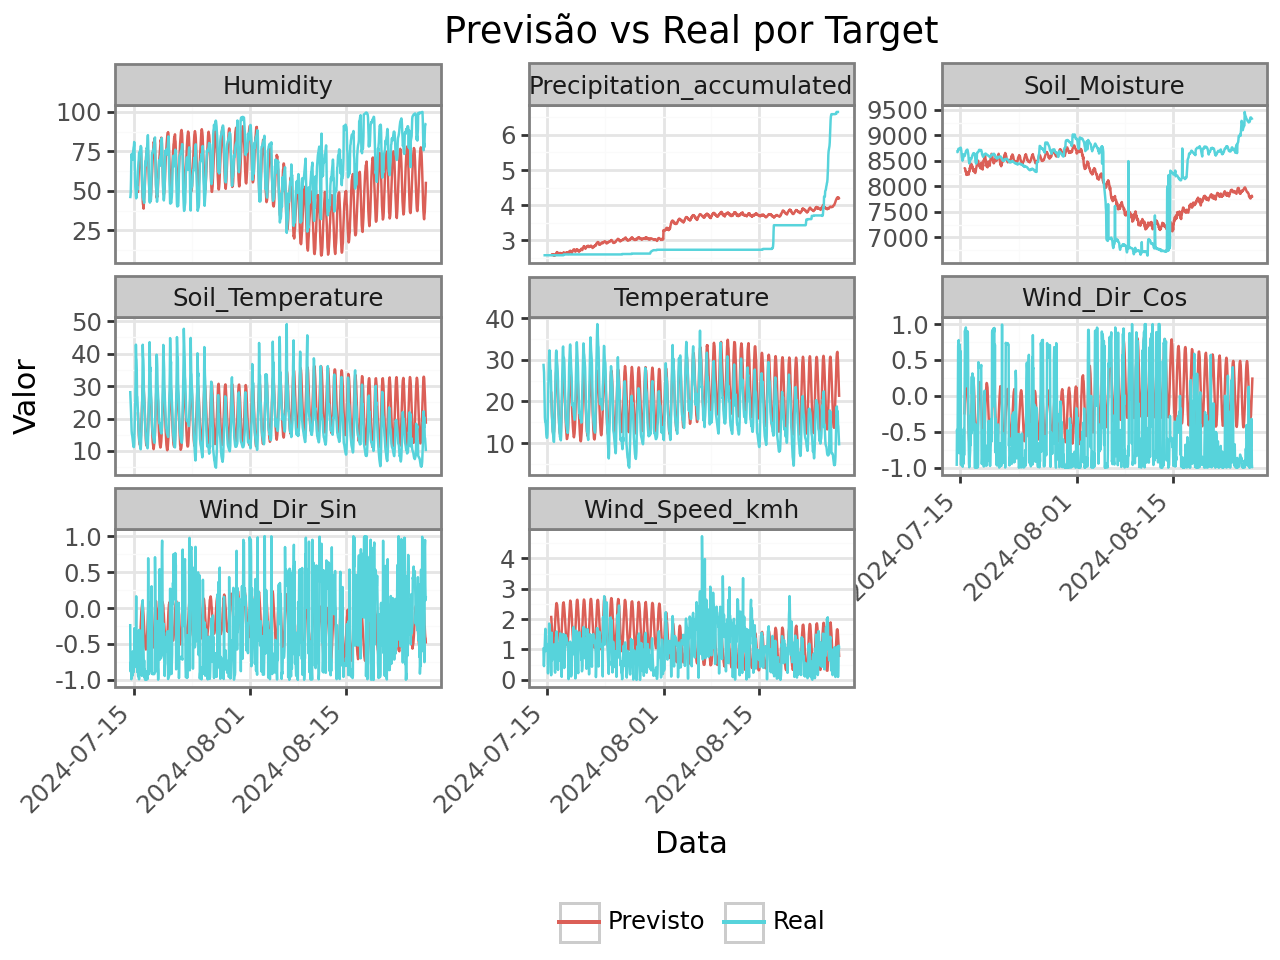

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

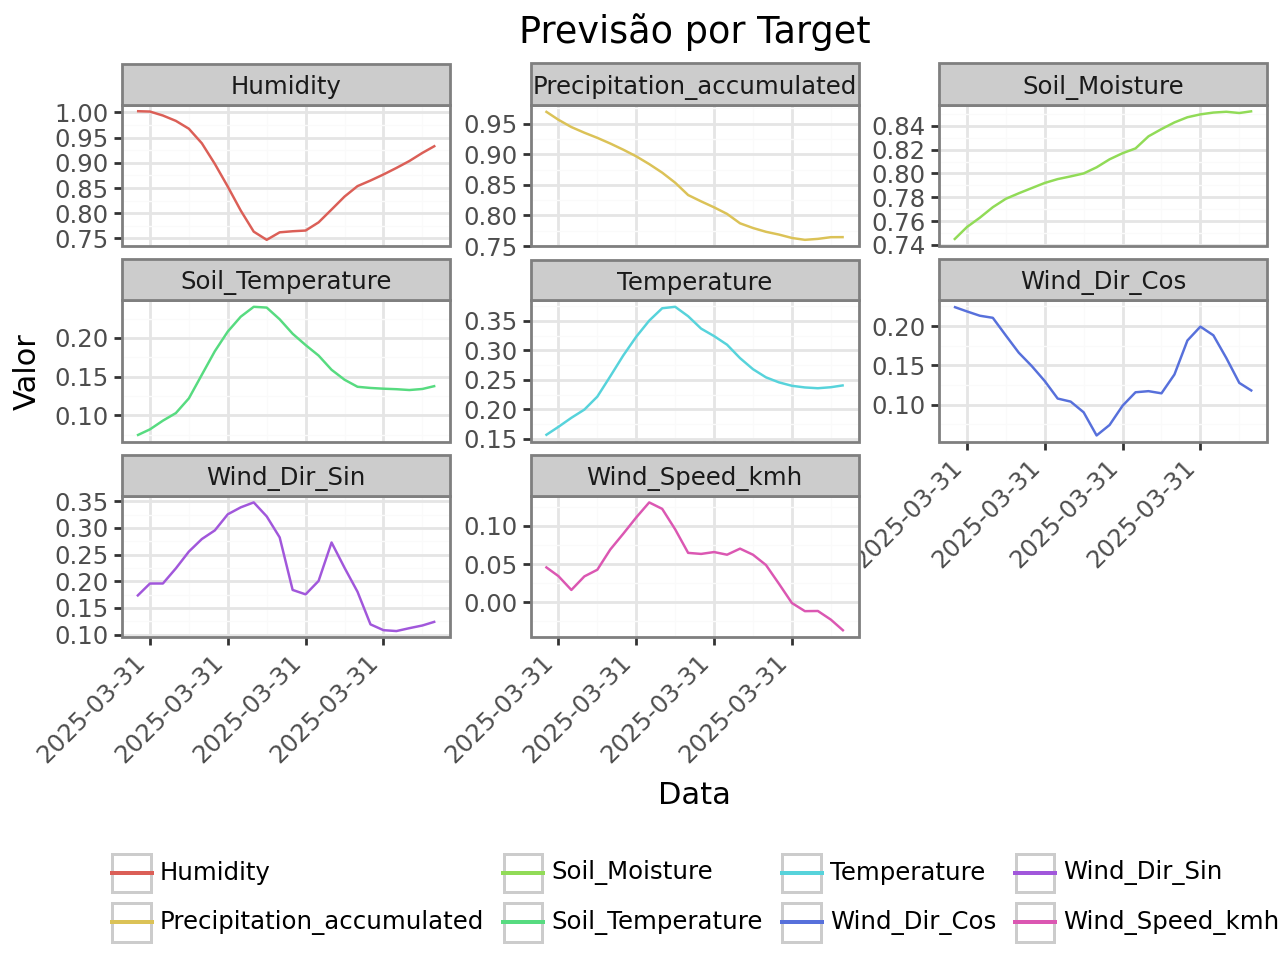

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)